In [1]:
from tqdm import tqdm
import re

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from flair.data import Sentence
from flair.models import SequenceTagger

In [2]:
# supress matplotlib warning

import warnings
warnings.filterwarnings('ignore')

## Data loading

In [3]:
# import dataset

FILES = {
    "DNC": "raw/2020 Debate Transcripts.csv",
    "Presidential": "raw/Presidential_debate_USA_final_October_2020.csv",
    "Vice Presidential": "raw/VP_debate_2020.csv",
}

# preview first 5 records

df = pd.read_csv(FILES["DNC"], encoding='cp1252')
df = df.replace('\n',' ', regex=True)
print(df.head())

# explore debate topics

topics = df['Topic'].unique()
print('\n number of topics: ', len(topics))

print('\n debate topics:')
for topic in topics:
    print('\n', topic)

   RowID  Original Row information       Date     Party        Location  \
0      1                         1  6/26/2019  Democrat  Miami, Florida   
1      2                         2  6/26/2019  Democrat  Miami, Florida   
2      3                         3  6/26/2019  Democrat  Miami, Florida   
3      4                         4  6/26/2019  Democrat  Miami, Florida   
4      5                         5  6/26/2019  Democrat  Miami, Florida   

   Speaker SpeakerInfo  Question    Topic  \
0     HOLT   Moderator       0.0  Opening   
1  GUTHRIE   Moderator       0.0  Opening   
2  GUTHRIE   Moderator       0.0  Opening   
3     HOLT   Moderator       0.0  Opening   
4  GUTHRIE   Moderator       0.0  Opening   

                                   Discourse w/names  \
0  HOLT: Good evening, everyone. I’m Lester Holt,...   
1  GUTHRIE: Hi, I’m Savannah Guthrie. And tonight...   
2  GUTHRIE: We’ll be joined in our questioning ti...   
3  HOLT: Voters are trying to nail down where the...  

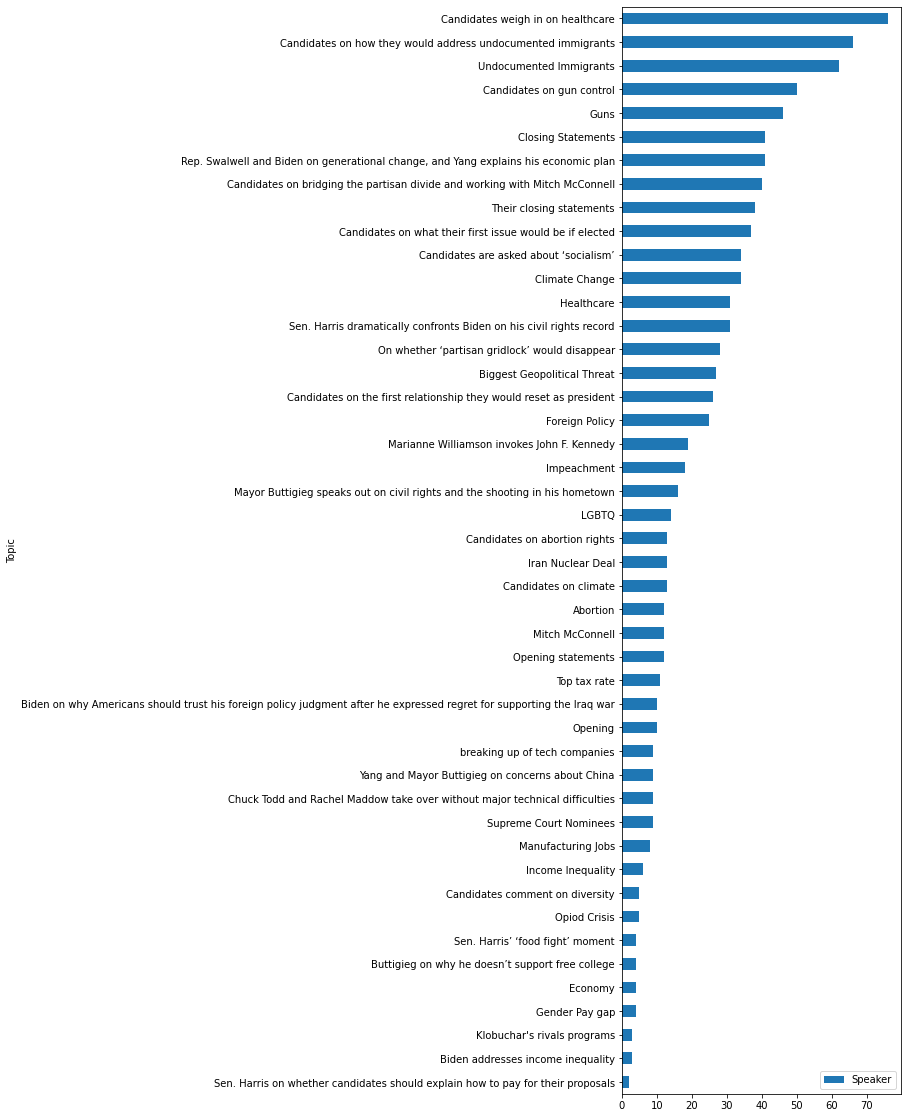

In [4]:
# topics by utterance frequency

speaker_topic = df[['Speaker','Topic']]
speaker_topic.groupby(['Topic']).count().sort_values(by='Speaker').plot(kind='barh', figsize=(5,20));

In [5]:
# check missing values

print("Missing 'Question' values? \n\n", df.loc[df.Question.isnull()], "\n\n")
print("Missing 'Topic' values? \n\n", df.loc[df.Topic.isnull()], "\n\n")
print("Missing 'SpeakerInfo' values? \n\n", df.loc[df.SpeakerInfo.isnull()])

Missing 'Question' values? 

      RowID  Original Row information       Date     Party        Location  \
406    407                         3  6/27/2019  Democrat  Miami, Florida   
407    408                         4  6/27/2019  Democrat  Miami, Florida   
408    409                         5  6/27/2019  Democrat  Miami, Florida   
409    410                         6  6/27/2019  Democrat  Miami, Florida   
410    411                         7  6/27/2019  Democrat  Miami, Florida   
411    412                         8  6/27/2019  Democrat  Miami, Florida   
412    413                         9  6/27/2019  Democrat  Miami, Florida   
413    414                        10  6/27/2019  Democrat  Miami, Florida   
414    415                        11  6/27/2019  Democrat  Miami, Florida   
415    416                        12  6/27/2019  Democrat  Miami, Florida   
416    417                        13  6/27/2019  Democrat  Miami, Florida   
417    418                        14  6/27/201

In [13]:
# make obvious corrections
# DIAZ-BALART is a moderator, not a candidate
# MADDOW is a moderator, not a candidate
#TODO: where df['Speaker'] == 'DE BLASIO' strip first 8 chars from ['Discourse w/o names']

df.loc[df['Speaker'] == 'DIAZ-BALART', 'SpeakerInfo'] = 'Moderator'
df.loc[df['Speaker'] == 'MADDOW', 'SpeakerInfo'] = 'Moderator'
print(df.loc[df.Speaker.eq('DIAZ-BALART')].head())
print(df.loc[df.Speaker.eq('MADDOW')].head())

# df.loc[df['Speaker'] == 'De Blasio', 'Discourse w/o names'] = df.loc[df['Speaker'] == 'De Blasio', 'Discourse w/o names'].str[8:]
# print(df.loc[df.Speaker.eq('DE BLASIO')].head())

    RowID  Original Row information       Date     Party        Location  \
8       9                         9  6/26/2019  Democrat  Miami, Florida   
41     42                        42  6/26/2019  Democrat  Miami, Florida   
43     44                        44  6/26/2019  Democrat  Miami, Florida   
45     46                        46  6/26/2019  Democrat  Miami, Florida   
47     48                        48  6/26/2019  Democrat  Miami, Florida   

        Speaker SpeakerInfo  Question               Topic  \
8   DIAZ-BALART   Moderator       0.0             Opening   
41  DIAZ-BALART   Moderator       6.0   Income Inequality   
43  DIAZ-BALART   Moderator       6.0   Income Inequality   
45  DIAZ-BALART   Moderator       6.0   Income Inequality   
47  DIAZ-BALART   Moderator       7.0  Manufacturing Jobs   

                                    Discourse w/names  \
8   DIAZ-BALART: And some quick rules of the road....   
41  DIAZ-BALART: Mayor De Blasio, good evening. Yo...   
43   

## Parsing of discourse into monlogues and dialogues

In [16]:
# 'Opening', Marianne Williamson invokes John F. Kennedy, Chuck Todd and Rachel Maddow take over without major technical difficulties --> skip
# 'Closing Statements', 'Their closing statements' excluding SpeakerInfo == 'moderator' --> monologues
# 'Biggest Geopolitical Threat', 'Candidates on what their first issue would be if elected' --> dialogues

# parse monologues and dialogues

monologues = df[0:0]
dialogues = df[0:0]

topics = np.delete(df['Topic'].unique(), [0, 1, 13, 15, 16, 19, 20, 21, 26, 29, 30, 32, 34, 41, 40, 45]) 

# manual parsing of 'Economy' (1)
tp = df.loc[df['Topic'] == 'Economy']
monologues = monologues.append(tp.iloc[3])
dialogues = dialogues.append(tp.iloc[0:2])

# manual parsing of 'Guns' (13)
tp = df.loc[df['Topic'] == 'Guns']
monologues = monologues.append(tp.iloc[22])
dialogues = dialogues.append(tp.iloc[23:46])

# manual parsing of 'Mitch McConnell' (15)
tp = df.loc[df['Topic'] == 'Mitch McConnell']
monologues = monologues.append(tp.iloc[3])
dialogues = dialogues.append(tp.iloc[4:12])

# manual parsing of 'Climate Change' (16)
tp = df.loc[df['Topic'] == 'Climate Change']
monologues = monologues.append(tp.iloc[5])
dialogues = dialogues.append(tp.iloc[6:34])

# manual parsing of 'Biggest Geopolitical Threat' (19)
tp = df.loc[df['Topic'] == 'Biggest Geopolitical Threat']
dialogues = dialogues.append(tp)

# manual parsing of 'Impeachment' (20)
tp = df.loc[df['Topic'] == 'Impeachment']
monologues = monologues.append(tp.iloc[2])
dialogues = dialogues.append(tp.iloc[3:18])

# manual parsing of 'Buttigieg on why he doesn’t support free college' (26)
tp = df.loc[df['Topic'] == 'Buttigieg on why he doesn’t support free college']
monologues = monologues.append(tp.iloc[3])
dialogues = dialogues.append(tp.iloc[[0, 2],:])

# manual parsing of 'Candidates weigh in on healthcare' (29)
tp = df.loc[df['Topic'] == 'Candidates weigh in on healthcare']
monologues = monologues.append(tp.iloc[5])
dialogues = dialogues.append(tp.iloc[6:77])

# manual parsing of 'Candidates on how they would address undocumented immigrants' (30)
tp = df.loc[df['Topic'] == 'Candidates on how they would address undocumented immigrants']
monologues = monologues.append(tp.iloc[3])
dialogues = dialogues.append(tp.iloc[4:66])

# Sen. Harris dramatically confronts Biden on his civil rights record (34)
tp = df.loc[df['Topic'] == 'Sen. Harris dramatically confronts Biden on his civil rights record']
monologues = monologues.append(tp.iloc[7])
dialogues = dialogues.append(tp.iloc[8:31])

# manual parsing of 'Candidates on what their first issue would be if elected' (41)
tp = df.loc[df['Topic'] == 'Candidates on what their first issue would be if elected']
dialogues = dialogues.append(tp)

for topic in topics:
    # print(df.loc[df['Topic'] == topic])
    tp = df.loc[df['Topic'] == topic]
    idx_mono = tp.SpeakerInfo.eq('Candidate').idxmax()
    # print('\n\n monologue idx: ', idx_mono, '\n\n')
    monologues = monologues.append(df.iloc[[idx_mono]])
    
    # determine last record; use idx_mono and idx_last to grab remaining discourse on the topic; this constitutes a dialogue
    idx = df.index
    idx_last = idx[df.RowID.eq(tp['RowID'].iloc[[-1]])][0]
    # print('\n\n last RowID of topic: ', idx_last, '\n\n')
    dialogues = dialogues.append(df.iloc[idx_mono:idx_last,:])

cs = df.loc[(((df['Topic'] == 'Closing Statements') | (df['Topic'] == 'Their closing statements')) & (df['SpeakerInfo'] == 'Candidate'))]
monologues = monologues.append(cs)

monologues.rename(columns = {'Discourse w/o names': 'Text'}, inplace = True)
dialogues.rename(columns = {'Discourse w/o names': 'Text'}, inplace = True)

print('\n number of monologues: ', len(monologues))
# print('\n\n monologues: \n\n', monologues)
print('\n\n number of dialogues: ', len(dialogues))
# print('\n\n dialogues: \n\n', dialogues)


 number of monologues:  68


 number of dialogues:  751


## Determine long monologues that should be manually parsed into halves/thirds

In [20]:
# count characters in 'text'; if greater than 1024 put into 'thirds'; else put into 'halves'; manually parse duplicates
halves = []
thirds = []

for row in monologues[['RowID', 'Text']].itertuples():
    if len(row.Text) > 1024:
        thirds.append(row.RowID)
    elif 512 < len(row.Text) < 1024:
        halves.append(row.RowID)

print('\n\n Monologues to be halved: \n\n', halves)
print('\n\n Monologues to be cut in thirds: \n\n',thirds)



 Monologues to be halved: 

 [14, 237, 688, 19, 39, 87, 100, 105, 167, 281, 410, 648, 713, 758, 784, 944, 367, 376, 379, 382, 388, 391, 393, 396, 399, 402, 954, 957, 960, 965, 968, 971, 974, 978, 980, 983]


 Monologues to be cut in thirds: 

 [201, 251, 348, 459, 510, 584, 16, 30, 43, 49, 57, 226, 296, 418, 421, 423, 501, 665, 718, 771, 871]


In [21]:
m = monologues['Text'].tolist()
d = dialogues['Text'].tolist()
print(len(m))
print(len(d))

68
751


## Tag utterances for POS using Flair library

In [24]:
# tag utterances

tagger = SequenceTagger.load('pos-fast')

corpus = m
tagged = []

for i in tqdm(corpus):
  sentence = Sentence(i)
  tagger.predict(sentence)
  tagged.append(sentence.to_tagged_string())

for i in range(1):
  print(tagged[i])
  print(corpus[i])

2021-09-18 14:29:41,696 https://nlp.informatik.hu-berlin.de/resources/models/pos-fast/en-pos-ontonotes-fast-v0.5.pt not found in cache, downloading to /tmp/tmpxeopw908



 65%|██████▌   | 49263616/75266317 [00:14<00:10, 2427185.37B/s]


 99%|█████████▉| 74559488/75266317 [00:28<00:00, 1303949.24B/s]


100%|██████████| 75266317/75266317 [00:29<00:00, 2585645.87B/s]

2021-09-18 14:30:11,047 copying /tmp/tmpxeopw908 to cache at /home/ebenge/.flair/models/en-pos-ontonotes-fast-v0.5.pt


2021-09-18 14:30:11,312 removing temp file /tmp/tmpxeopw908
2021-09-18 14:30:11,341 loading file /home/ebenge/.flair/models/en-pos-ontonotes-fast-v0.5.pt



 20%|██        | 15191040/75266317 [01:18<05:09, 194176.33B/s]

100%|██████████| 68/68 [02:31<00:00,  2.23s/it]

So <RB> I <PRP> think <VBP> of <IN> it <PRP> this <DT> way <NN> . <,> Who <WP> is <VBZ> this <DT> economy <NN> really <RB> working <VBG> for <IN> ? <,> It <PRP> ’s <VBZ> doing <VBG> great <RB> for <IN> a <DT> thinner <JJR> and <CC> thinner <JJR> slice <NN> at <IN> the <DT> top <NN> . <.> It <PRP> ’s <VBZ> doing <VBG> great <RB> for <IN> giant <JJ> drug <NN> companies <NNS> . <,> It <PRP> ’s <VBZ> just <RB> not <RB> doing <VBG> great <RB> for <IN> people <NNS> who <WP> are <VBP> trying <VBG> to <TO> get <VB> a <DT> prescription <NN> filled <VBN> . <.> It <PRP> ’s <VBZ> doing <VBG> great <RB> for <IN> people <NNS> who <WP> want <VBP> to <TO> invest <VB> in <IN> private <JJ> prisons <NNS> , <,> just <RB> not <RB> for <IN> the <DT> African-Americans <NNPS> and <CC> Latinos <NNPS> whose <WP$> families <NNS> are <VBP> torn <VBN> apart <RB> , <,> whose <WP$> lives <NNS> are <VBP> destroyed <VBN> , <,> and <CC> whose <WP$> communities <NNS> are <VBP> ruined <VBN> . <,> It <PRP> ’s <VBZ> doing 

In [29]:
# extract tags 

for i in tqdm(range(len(tagged))):
  for j in corpus[i].split():
    tagged[i] = str(tagged[i]).replace(j,"",1)

  # remove < > characters
  for j in  ['<','>']:
    tagged[i] = str(tagged[i]).replace(j,"")
    # remove redundant spaces
    tagged[i] = re.sub(' +', ' ', str(tagged[i]))
    tagged[i] = str(tagged[i]).lstrip()

for i in range(1):
  print(tagged[i])
  print(corpus[i])

100%|██████████| 68/68 [00:00<00:00, 438.21it/s]

RB PRP VBP IN PRP DT wy NN . , WP VBZ DT NN RB VBG IN ? , It PRP ’s VBZ VBG RB IN DT JJR CC JJR NN IN DT p NN . . It PRP ’s VBZ VBG RB IN JJ NN NNS . , It PRP ’s VBZ RB RB VBG RB IN NNS WP VBP VBG TO VB DT NN filled VBN . . It PRP ’s VBZ VBG RB IN NNS WP VBP TO VB IN JJ prons NNS , , RB RB IN DT NNPS CC NNPS WP$ NNS VBP VBN apart RB , , WP$ NNS VBP destroyed VBN , , CC WP$ NNS VBP rued VBN . , It PRP ’s VBZ VBG RB IN JJ NN compies NNS WDT VBP TO VB everywhere RB , , RB RB IN DT NN IN PRP WP VBP VBG NN NN VB RP IN us PRP . , WRB you PRP ’ve VBP VBN a DT government NN , , WRB you PRP ’ve VBP VBN an DT NN WDT VBZ JJ IN DT IN NN CC is VBZ n’t RB VBG RB for IN NN else RB , , DT is VBZ corruption NN , , JJ CC simple JJ . , PRP VBP TO VB PRP out RP . , PRP VBP TO VB PRP RB on RB . , CC PRP VBP to TO VB JJ NN IN PRP$ government NN , , IN PRP$ economy NN , , CC in IN PRP$ country NN . .
So I think of it this way. Who is this economy really working for? It’s doing great for a thinner and thinner

In [30]:
for i in tqdm(range(len(corpus))):
  # remove symbols
  # corpus[i] = re.sub('[^a-zA-Z]', ' ', str(corpus[i]))
  tagged[i] = re.sub('[^a-zA-Z]', ' ', str(tagged[i]))

  ## remove HYPH SYM
  tagged[i] = str(tagged[i]).replace('HYPH',"")
  tagged[i] = str(tagged[i]).replace('SYM',"")                    

  # remove redundant space
  # corpus[i] = re.sub(' +', ' ', str(corpus[i]))
  tagged[i] = re.sub(' +', ' ', str(tagged[i]))

100%|██████████| 68/68 [00:00<00:00, 1999.89it/s]


In [31]:
# check tags 

for i in range(3):
  print('monologue:\n\n'+corpus[i]+'\n') 
  print('tagged:\n\n'+tagged[i]+'\n')
  print('-'*90+'\n')

monologue:

So I think of it this way. Who is this economy really working for? It’s doing great for a thinner and thinner slice at the top. It’s doing great for giant drug companies. It’s just not doing great for people who are trying to get a prescription filled. It’s doing great for people who want to invest in private prisons, just not for the African-Americans and Latinos whose families are torn apart, whose lives are destroyed, and whose communities are ruined. It’s doing great for giant oil companies that want to drill everywhere, just not for the rest of us who are watching climate change bear down upon us. When you’ve got a government, when you’ve got an economy that does great for those with money and isn’t doing great for everyone else, that is corruption, pure and simple. We need to call it out. We need to attack it head on. And we need to make structural change in our government, in our economy, and in our country.

tagged:

RB PRP VBP IN PRP DT wy NN WP VBZ DT NN RB VBG IN

100%|██████████| 68/68 [00:00<00:00, 6121.89it/s]


Counter({'<NN>': 1327, '<IN>': 1209, '<DT>': 1028, '<PRP>': 983, '<VB>': 622, '<VBP>': 554, '<RB>': 522, '<JJ>': 493, '<NNS>': 454, '<CC>': 437, '<NNP>': 410, '<VBZ>': 377, '<TO>': 300, 'I': 285, '<VBG>': 246, '<MD>': 203, '<VBN>': 200, '<PRP$>': 193, '<VBD>': 188, '<CD>': 150, '<WP>': 135, '<WDT>': 113, '<WRB>': 93, '<RP>': 51, '<JJR>': 32, '<UH>': 31, '<JJS>': 26, '<NNPS>': 23, '<EX>': 21, '<RBR>': 19, '<POS>': 10, '<RBS>': 9})


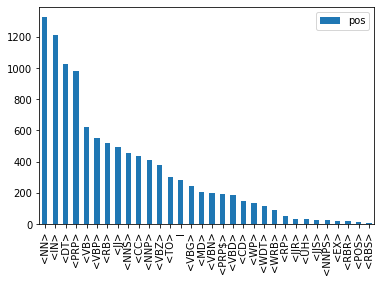

In [26]:
from collections import Counter

# unpack tagged

pos = []

for i in tqdm(range(len(tagged))):
    pos.extend(tagged[i].split())

c = Counter(pos)
count = Counter({k: c for k, c in c.items() if k.isupper() if c > 8})

print(count)

tags = pd.DataFrame().from_dict(count, orient='index')
tags.columns = ['pos']
tags.sort_values(by='pos', ascending=False).plot(kind='bar')
plt.show()

# NN - Noun, singular or mass, PRP - Personal pronoun, DT - Determiner, 
# IN - Preposition or subordinating conjunction, VB - Verb, base form, VBP - Verb, non-3rd person singular present, 
# RB - Adverb, JJ - Adjective, NNS - Noun, plural, NNP - Proper noun, singular, CC - Coordinating conjunction, 
# VBZ - Verb, 3rd person singular present, TO - to, VBG - Verb, gerund or present participle, 
# VBD - Verb, past tense, VBN - Verb, past participle, MD - Modal, CD - Cardinal number, WP - Wh-pronoun, 
# WDT - Wh-determiner, WRB - Wh-adverb, RP - Particle, UH - Interjection, JJR - Adjective, comparative, 
# JJS - Adjective, superlative, NNPS - Proper noun, plural, EX - Existential there, RBR Adverb, comparative, 
# POS - Possessive ending, RRB - ?, FW - Foreign word, RBS - Adverb, superlative, PDT - Predeterminer
# LRB - ?, NFP - Superfluous punctuation

## Write out monologues and dialogues to TSV files

In [27]:
mono_output = monologues[['RowID', 'Speaker', 'SpeakerInfo', 'Question', 'Topic', 'Text']]
dia_output = dialogues[['RowID', 'Speaker', 'SpeakerInfo', 'Question', 'Topic', 'Text']]

# mono_output.to_csv('processed/dnc_debate_monologues.tsv', sep = '\t', index=False)
# dia_output.to_csv('processed/dnc_debate_dialogues.tsv', sep = '\t', index=False)

In [34]:
# dnc monologues for dnc_mono = pd.read_csv('processed/dnc_debate_monologues.tsv', sep = '\t')
# dnc_mono = dnc_mono[['RowID', 'Topic', 'Speaker', 'Text']]
# dnc_mono.to_csv('processed/dnc_monologues_for_pres.tsv', sep = '\t', index=False)                    

## Process TSV files for MLM

The manually parsed monologue dataset is named `dnc_debate_monologues_parsed.tsv`. A copy named `dnc_debate_monologues_for_MLM.tsv` is made in order to preserve the naming convention. 

In [49]:
_df = pd.read_csv('processed/dnc_debate_dialogues.tsv', sep = '\t')
df = _df.sample(n = 155)
df.to_csv('processed/dnc_debate_dialogues_for_MLM.tsv', sep = '\t', index=False)                    

## Process TSV files for NSP

In [45]:
# import dataset

FILES = {
    "Monologue": "processed/dnc_debate_monologues.tsv",
    "Dialogue": "processed/dnc_debate_dialogues.tsv",
}

# preview first 5 records

df = pd.read_csv(FILES["Dialogue"], sep = '\t', usecols = ['Topic','Text'])
print(df.head())

     Topic                                               Text
0  Economy  All right. So with that business out of the wa...
1  Economy                        Thank you. Good to be here.
2     Guns  OK, thank you, Senator Warren. You didn’t addr...
3     Guns  What I think we need to do is we need to treat...
4     Guns  Thank you, Senator. Senator Booker, you have a...


In [44]:
topics = df['Topic'].unique().tolist()
text = df[0:0]
# text = pd.DataFrame(columns=['Text'])

for topic in topics:
    tp = df.loc[df['Topic'] == topic]
    for index, row in tp.iterrows():
        sentences = re.split(r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|!)\s", row['Text'])
        for i in range(len(sentences)):
            _row = [topic, sentences[i]]
            _series = pd.Series(_row, index = df.columns)
            text = text.append(_series, ignore_index=True)
            
    _series = pd.Series([np.nan, np.nan], index = df.columns)
    text = text.append(_series, ignore_index=True)
    
print(text.head())

# text.to_csv('processed/dnc_debate_dialogues_for_NSP.tsv', sep = '\t', index=False)

# file = 'processed/dnc_debate_dialogues_for_NSP.tsv'

f = open(file, 'r')
text = f.read()
f.close()
text = text.replace("\"\"","")
f = open(file, 'w')
f.write(text)
f.close()

     Topic                                               Text
0  Economy                                         All right.
1  Economy  So with that business out of the way, we want ...
2  Economy  And we’ll start this evening with Senator Eliz...
3  Economy                                         Thank you.
4  Economy                                   Good to be here.


In [57]:
topics = df['Topic'].unique().tolist()
print(topics)

['Economy', 'Guns', 'Mitch McConnell', 'Climate Change', 'Biggest Geopolitical Threat', 'Impeachment', 'Buttigieg on why he doesn’t support free college', 'Candidates weigh in on healthcare', 'Candidates on how they would address undocumented immigrants', 'Sen. Harris dramatically confronts Biden on his civil rights record', 'Candidates on what their first issue would be if elected', "Klobuchar's rivals programs", 'Top tax rate', 'breaking up of tech companies', 'Gender Pay gap', 'Income Inequality', 'Manufacturing Jobs', 'Healthcare', 'Abortion', 'Opiod Crisis', 'Undocumented Immigrants', 'Iran Nuclear Deal', 'Supreme Court Nominees', 'LGBTQ', 'Foreign Policy', 'Opening statements', 'Biden addresses income inequality', 'Candidates are asked about ‘socialism’', 'Rep. Swalwell and Biden on generational change, and Yang explains his economic plan', 'Sen. Harris’ ‘food fight’ moment', 'Yang and Mayor Buttigieg on concerns about China', 'Mayor Buttigieg speaks out on civil rights and the s

At this point I take half of the topics from the dialogue dataset and combine them with the other half of the topics from the monologue dataset. This makes up the training dataset. The inverse topics are then selection from the inverse datasets and this makes up the validation dataset. Each topic constitutes a 'document' in the setting of next sentence prediction. The resulting datasets are named `dnc_debate_train_for_NSP.tsv` and `dnc_debate_val_for_NSP.tsv`.

## Process TSV files for SeqClassif

I take half of the topics from the dialogue dataset and combine them with the other half of the topics from the monologue dataset. This makes up the training dataset. The inverse topics are then selection from the inverse datasets and this makes up the validation dataset. Utterances/Sentences from the monologue dataset are given the label 1 and those from the dialogue dataset are given the label 0. Extra examples are deleted in order to maintain balanced training and validation datasets. The resulting datasets are named `dnc_debate_train_for_SC.tsv` and `dnc_debate_val_for_SC.tsv`.

In [63]:
# import dataset

FILES = {
    "train": "processed/dnc_debate_train_for_SC.tsv",
    "val": "processed/dnc_debate_val_for_SC.tsv",
}

# preview first 5 records

df = pd.read_csv(FILES["train"], sep = '\t', usecols = ['label','text'])
df['text'] = df['text'].astype('str') 
print(df.head())
print(df.dtypes)

   label                                               text
0      1                                         All right.
1      1  So with that business out of the way, we want ...
2      1  And we’ll start this evening with Senator Eliz...
3      1                                         Thank you.
4      1                                   Good to be here.
label     int64
text     object
dtype: object
